# Part 1: Data from a mysterious celltype

Your collaborators performed ChIP-seq for two different factors in a mysterious new cell type.

They send you a file with DNA sequences and the matched profiles for a set of regions.

They believe there is an interaction between the two factors, but would like your help modeling and analyzing the data. 

Try to answer their questions concisely.


In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import io
import h5py
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Reshape, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Accuracy
from tensorflow import argmax
from tensorflow import GradientTape
from tensorflow import Variable

# Below is required for saliency mapping
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
import random
random.seed(123) 

In [3]:
def download_h5(dataset_url, filename = 'dataset.h5'):
  with requests.Session() as session:
      r = session.get(dataset_url, stream=True)
      r.raise_for_status()
      with open(filename, 'wb') as hd5:
          for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
              hd5.write(chunk)

In [4]:
DATA_URL = 'https://raw.githubusercontent.com/Fudenberg-Research-Group/2022_seq-to-profile/main/dataset1.h5'

download_h5(DATA_URL, filename = 'dataset1.h5')

In [5]:
### reading in the h5 data 
with h5py.File('dataset1.h5', 'r') as h:
     sequences = h['seqs'].asstr()[()]
     targets = h['targets'][()]

Text(0.5, 0, 'position, bp')

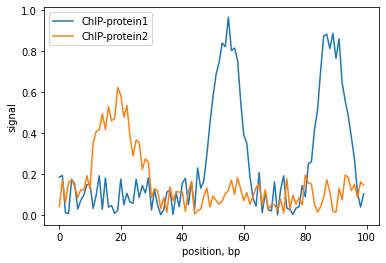

In [6]:
## To take a quick look at one of their profiles
plt.plot( targets[0,:,0], label='ChIP-protein1');

plt.plot( targets[0,:,1], label='ChIP-protein2');
plt.legend()
plt.ylabel("signal")
plt.xlabel("position, bp")

## 1.0 Try to fit the data with a seq-to-profile neural network. 
- Follow similar steps to those taken in the [Zou et al primer](https://colab.research.google.com/drive/17E4h5aAOioh5DiTo7MZg4hpL6Z_0FyWr#scrollTo=qSOUwoG_vHRA), e.g.: 
  - one-hot encode the DNA, 
  - set aside a test set, 
  - define a convolutional architecture, perhaps with additional or modified layers
  - consider what sort of loss function and activation to use. 
- Use [EarlyStopping](https://keras.io/api/callbacks/early_stopping/)
- Report your test set accuracy. Report an interpretable metric as well. 
- Where does the model do well or struggle? 


Note: if the validation loss is not decreasing during training, the specified model may not be well-matched for the problem at hand. Consider how to modify the model (e.g. a model with sigmoid activation at the final layer would never be able to learn negative values).

In [7]:
## One-hot encode of DNA sequence
integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

input_features = np.stack(input_features)
input_labels = targets # Signal values are labels
maxsignal = input_labels.max()
minsignal = input_labels.min()

# Divide the data: Create test and train data
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

#print(train_features.shape) # (3750, 100, 4)
#print(train_labels.shape) # (3750, 100, 2)

In [8]:
# Pearson for metric
from keras import backend as K
def pearson_r(y_true, y_pred):
    # pearson correlation coefficient
    # source: https://github.com/WenYanger/Keras_Metrics
    # provided after office hours
    epsilon = 10e-5
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / (r_den + epsilon)
    return K.mean(r)

In [9]:
# Setup the model
model = Sequential() #sequential architecture

model.add(Conv1D(filters=32, kernel_size=16, 
                 input_shape=(train_features.shape[1], 4), padding='same'))
model.add(MaxPooling1D(pool_size=12, strides=1, padding="same"))
model.add(Dense(300, activation='relu'))
model.add(Dense(2))

model.compile(loss='mse', optimizer="adam", metrics=[pearson_r])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 32)          0         
 )                                                               
                                                                 
 dense (Dense)               (None, 100, 300)          9900      
                                                                 
 dense_1 (Dense)             (None, 100, 2)            602       
                                                                 
Total params: 12,582
Trainable params: 12,582
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Define callback function to prevent overfitting
callback = EarlyStopping(monitor='loss', patience=3)

# Fit the model 
history = model.fit(train_features, train_labels, epochs=100, verbose=0, 
                    validation_split=0.25, callbacks=[callback]) 

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


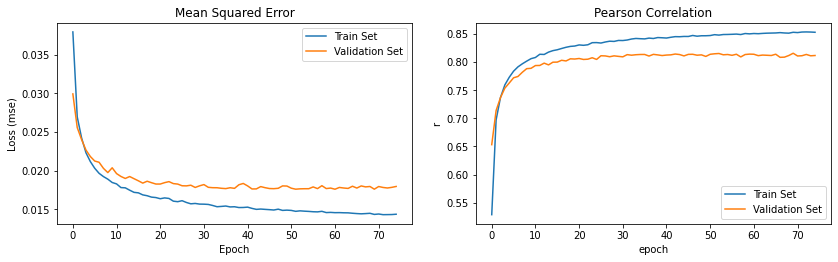

In [11]:
# Figure 1-A: Epoch vs Loss
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Mean Squared Error')
ax1.set(ylabel='Loss (mse)', xlabel='Epoch')
ax1.legend(['Train Set', 'Validation Set'])

# Figure 1-B: Epoch vs Loss
ax2.plot(history.history['pearson_r'])
ax2.plot(history.history['val_pearson_r'])
ax2.set_title('Pearson Correlation')
ax2.set(ylabel='r', xlabel='epoch')
ax2.legend(['Train Set', 'Validation Set'])

fig1.tight_layout(pad=2.0)
fig1.show()

In [12]:
# Evaluate the models accuracy
score_train = model.evaluate(train_features, train_labels, verbose = True) # loss: 0.0151 - pearson_r: 0.8433
score_test  = model.evaluate(test_features, test_labels, verbose = True) # loss: 0.0177 - pearson_r: 0.8114

In [13]:
# Use test set for predictions
test_prediction = model.predict(test_features, verbose = True)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


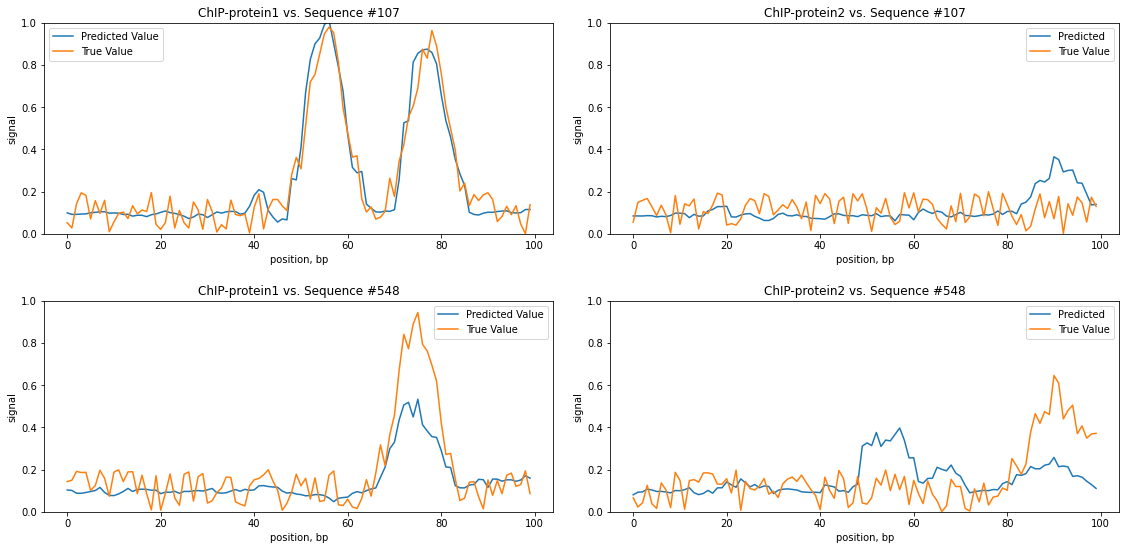

In [14]:
# Investigation of the prediction on randomly selected 2 sequences
nseqs = 2
fig, axes = plt.subplots(nseqs, 2, figsize=(16,nseqs*4))
for i in range(nseqs):
        seq = random.randint(0,1250) 
        
        axes[i][0].plot(test_prediction[seq,:,0])
        axes[i][0].plot(test_labels[seq,:,0])
        axes[i][0].set_ylim((0, maxsignal))
        axes[i][0].set_title('ChIP-protein1 vs. Sequence #' + str(seq))
        axes[i][0].set(ylabel='signal', xlabel='position, bp')
        axes[i][0].legend(['Predicted Value', 'True Value'])
        
        axes[i][1].plot(test_prediction[seq,:,1])
        axes[i][1].plot(test_labels[seq,:,1])
        axes[i][1].set_ylim((0, maxsignal))
        axes[i][1].set_title('ChIP-protein2 vs. Sequence #' + str(seq))
        axes[i][1].set(ylabel='signal', xlabel='position, bp')
        axes[i][1].legend(['Predicted', 'True Value'])

fig.tight_layout(pad=2.0)
fig.show()

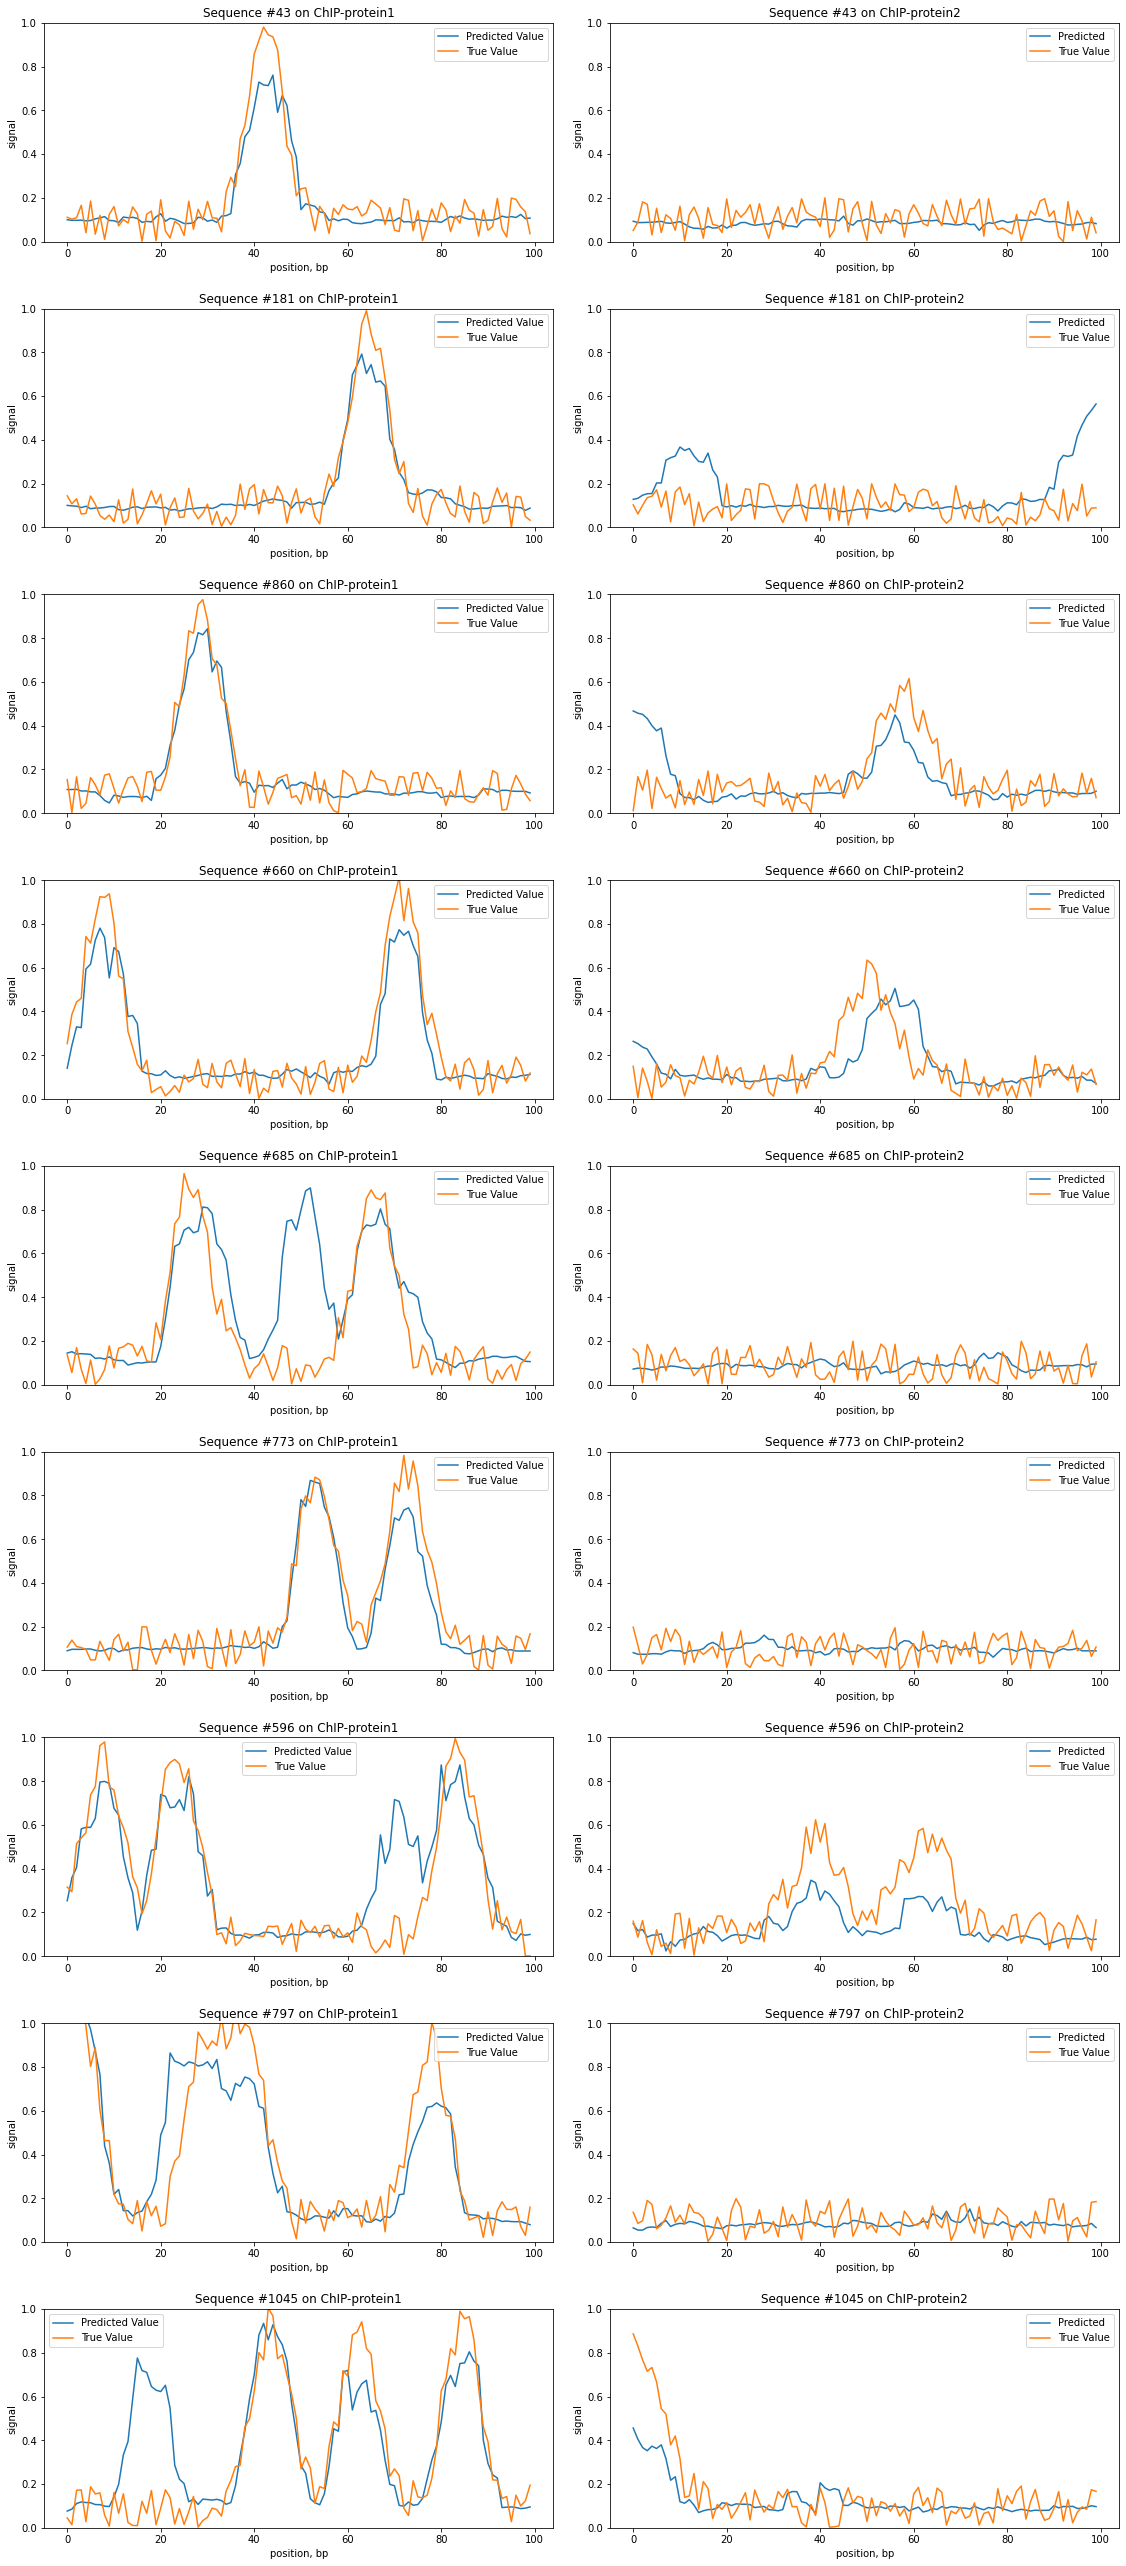

In [15]:
# Some observations on specific sequences 
seqs_1p = [43, 181, 860] #seqs with single peak
seqs_2p = [660, 685, 773] #seqs with two peaks
seqs_3p = [596, 797, 1045] #seqs with 3 or more peaks

nseqs = 9
fig, axes = plt.subplots(nseqs, 2, figsize=(16,nseqs*4))
for i in range(nseqs):
        if i in range(0,3): seq = seqs_1p[i]
        if i in range(3,6): seq = seqs_2p[i-3]
        if i in range(6,9): seq = seqs_3p[i-6]

        axes[i][0].plot(test_prediction[seq,:,0])
        axes[i][0].plot(test_labels[seq,:,0])
        axes[i][0].set_ylim((0, maxsignal))
        axes[i][0].set_title('Sequence #' + str(seq) + ' on ChIP-protein1')
        axes[i][0].set(ylabel='signal', xlabel='position, bp')
        axes[i][0].legend(['Predicted Value', 'True Value'])
        
        axes[i][1].plot(test_prediction[seq,:,1])
        axes[i][1].plot(test_labels[seq,:,1])
        axes[i][1].set_ylim((0, maxsignal))
        axes[i][1].set_title('Sequence #' + str(seq) + ' on ChIP-protein2')
        axes[i][1].set(ylabel='signal', xlabel='position, bp')
        axes[i][1].legend(['Predicted', 'True Value'])

fig.tight_layout(pad=2.0)
fig.show()

## Answer to Question 1.0

Q: Follow similar steps to those taken in the [Zou et al primer](https://colab.research.google.com/drive/17E4h5aAOioh5DiTo7MZg4hpL6Z_0FyWr#scrollTo=qSOUwoG_vHRA). Consider what sort of loss function and activation to use. 

- We followed the steps in the primer tutorial ([Zou et al](https://colab.research.google.com/drive/17E4h5aAOioh5DiTo7MZg4hpL6Z_0FyWr#scrollTo=qSOUwoG_vHRA)): We set up the architecture of our network model with sequental convolution, max-pooling and dense layers, and used it to fit the data we are provided. We defined our loss function as the mean squared error (mse) to ensure our trained model has no outlier predictions, and we chose ReLu as our activation method since the data we have were Chip-Seq signals. With this setup, we obtained 12,582 trainable parameters for our predictions. After obtainin the model, we have used 75% of the data for training.

Q: Use [EarlyStopping](https://keras.io/api/callbacks/early_stopping/).
- In Figure 1, we can see that the model training stops if there is no improvement in the loss function after 3 epoch steps (this is ensured by setting a callback function with a patience parameter of 3 in EarlyStopping). This way, we were able to prevent overfitting.

Q: Report your test set accuracy. Report an interpretable metric as well. 
- After training, we obtained a model with a mean-squared error of 0.015 between the test (75% of the training set) and validation (25% of the training set) data. The accuracy of the predictions were computed as r=0.84 according to Pearson's correlation (r=1 would mean a perfect prediction). When we used our model to predict signal values for the test set (that our model has never been introduced during training), we obtained a mean-squared error of 0.018 and r=0.81. We used Pearson’s correlation coefficient as our metric since the singal values in our data were continuous and not binary. 

Q: Where does the model do well or struggle? 
- Further investigation of the predictions for randomly selected sequences showed that when the real data had a single peak, our model was able to predict it with high accuracy most of the time; however, if the number of peaks increased, we saw a decrease in the prediction accuracy (this behaviour can be observed in Figure 3).



## 1.1 Can you determine any rule(s) that influence the profiles for the two factors?
Try saliency mapping as employed in the primer. Are there motifs, or an interplay between motifs, that boost or dampen the profiles? 

In [16]:
# Saliency Mapping

def compute_salient_bases(model, x, protein):
  total = 0
  for i in range(model.output.shape[1]-1):
    total=total+model.output[0][i][protein]
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(total, model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal


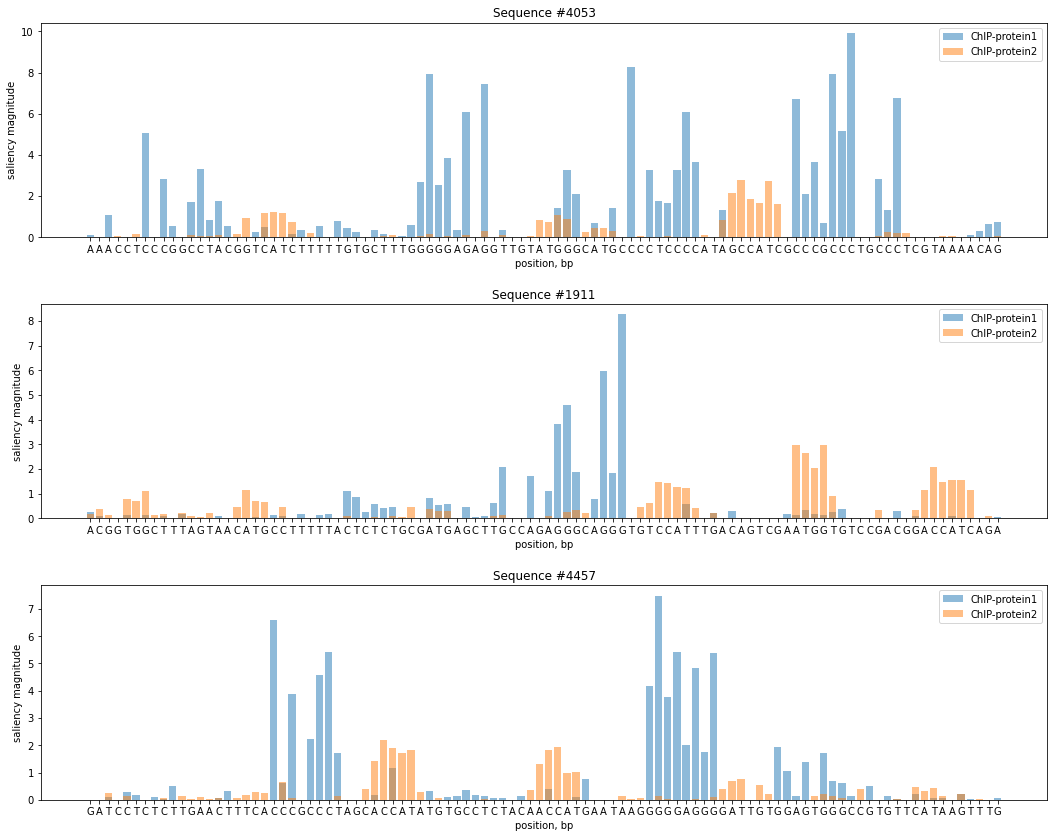

In [149]:
nbar = 100 # number of bp
nseqs = 3
sal_sequences = random.sample(range(0, 5001), nseqs)

fig, axes = plt.subplots(nseqs, 1, figsize=(15,nseqs*4))
counter = 0
for i in sal_sequences:
    sal_protein1 = compute_salient_bases(model, input_features[i], 0)
    sal_protein2 = compute_salient_bases(model, input_features[i], 1)

    axes[counter].bar(np.arange(nbar), sal_protein1, alpha=0.5, label = 'ChIP-protein1')
    axes[counter].bar(np.arange(nbar), sal_protein2, alpha=0.5, label = 'ChIP-protein2')
    axes[counter].set(ylabel='saliency magnitude')
    axes[counter].set_xticks(np.arange(nbar))
    axes[counter].set_xticklabels(list(sequences[i]))
    axes[counter].set_title('Sequence #' + str(i));
    axes[counter].legend()
    counter += 1

fig.tight_layout(pad=2.0)
fig.show()

## Answer to Question 1.1 
Q: Can you determine any rule(s) that influence the profiles for the two factors? Try saliency mapping as employed in the primer. Are there motifs, or an interplay between motifs, that boost or dampen the profiles? 

- From saliency figures, there are no overlapping peaks between Protein 1 and Protein 2 for specific bp regions. We can conclude that there are no motifs or interplays, therefore we can say there isn't an interaction between the two factors.

#Part 2: More data from another mysterious cell type

Your collaborators send you an update: they performed ChIP-seq for the same two factors in a yet another mysterious cell type and are getting puzzling results. They send you a second file. Seems like they are pretty good collaborators!

In [66]:
DATA_URL2 = 'https://raw.githubusercontent.com/Fudenberg-Research-Group/2022_seq-to-profile/main/dataset2.h5'

download_h5(DATA_URL2, filename = 'dataset2.h5')

### reading in the h5 data 
with h5py.File('dataset2.h5', 'r') as h:
     sequences_2 = h['seqs'].asstr()[()]
     targets_2 = h['targets'][()]

## One-hot encode of DNA sequence
integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences_2:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

input_features_2 = np.stack(input_features)
input_labels_2 = targets_2


maxsignal_2 = input_labels_2.max()
minsignal_2 = input_labels_2.min()

## 2.0 Does your model trained on the original data predict this data well or poorly? 

In [71]:
# Predict the data using the model trained on the original data
test_prediction_2 = model.predict(input_features_2, verbose = True)
score_2 = model.evaluate(input_features_2, input_labels_2, verbose = True) # loss = 0.16295890698432922 - pearson_r = 0.80368334

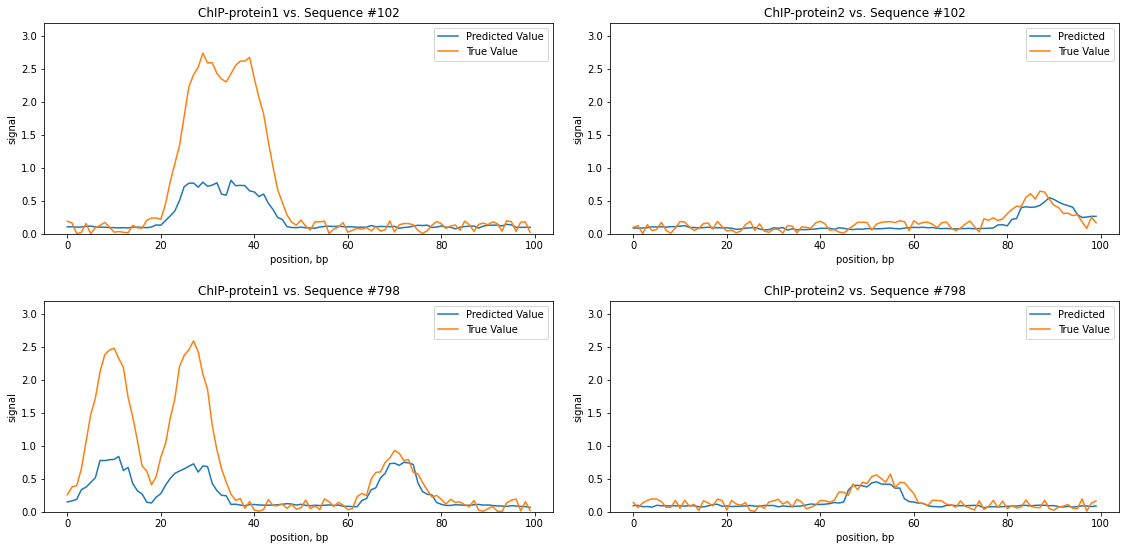

In [128]:
# Investigation of the prediction on specifically selected 2 sequences
nseqs = [102, 798]
fig, axes = plt.subplots(2, 2, figsize=(16,8))
for i in range(0,2):
        seq = nseqs[i]
        
        axes[i][0].plot(test_prediction_2[seq,:,0])
        axes[i][0].plot(input_labels_2[seq,:,0])
        axes[i][0].set_ylim((0, maxsignal_2))
        axes[i][0].set_title('ChIP-protein1 vs. Sequence #' + str(seq))
        axes[i][0].set(ylabel='signal', xlabel='position, bp')
        axes[i][0].legend(['Predicted Value', 'True Value'])
        
        axes[i][1].plot(test_prediction_2[seq,:,1])
        axes[i][1].plot(input_labels_2[seq,:,1])
        axes[i][1].set_ylim((0, maxsignal_2))
        axes[i][1].set_title('ChIP-protein2 vs. Sequence #' + str(seq))
        axes[i][1].set(ylabel='signal', xlabel='position, bp')
        axes[i][1].legend(['Predicted', 'True Value'])

fig.tight_layout(pad=2.0)
fig.show()

## Answer to Question 2.0 

Does your model trained on the original data predict this data well or poorly? 
- The accuracy of the predictions were computed as r=0.80 according to Pearson's correlation (a bit decreased compared to the original data set predictions), with a mean-squared error of 0.16. Although the r value is quite the same, our mean-squared error is almost 10 times higher than the previous predictions with this new data. The reason could be due to higher signal values in the new dataset (maximum signal was 1.20, but the new dataset has a maximum signal value of 3.20). It is expected to see that our model could not predict those high signals, because it was trained in the previous range (Figure shows 2 example sequences).

## 2.1 Does a model re-trained on this new dataset reach the same level of predictive ability?

In [107]:
# Divide data into test and train
train_features_2, test_features_2, train_labels_2, test_labels_2 = train_test_split(
    input_features_2, input_labels_2, test_size=0.25, random_state=42)

# Re-training
history_2 = model.fit(train_features_2, train_labels_2, epochs=100, verbose=0, validation_split=0.25,callbacks=[callback])

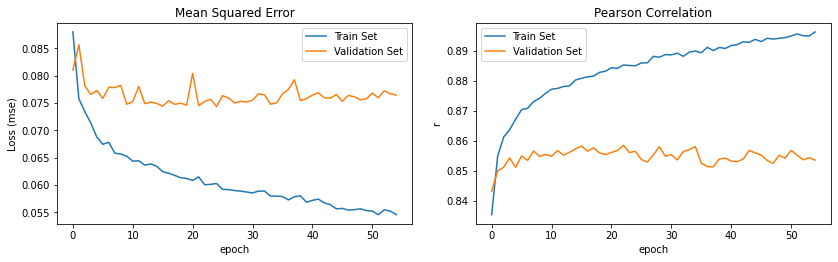

In [111]:
# Figure 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history_2.history['loss'])
ax1.plot(history_2.history['val_loss'])
ax1.set_title('Mean Squared Error')
ax1.set(ylabel='Loss (mse)', xlabel='epoch')
ax1.legend(['Train Set', 'Validation Set'])

ax2.plot(history_2.history['pearson_r'])
ax2.plot(history_2.history['val_pearson_r'])
ax2.set_title('Pearson Correlation')
ax2.set(ylabel='r', xlabel='epoch')
ax2.legend(['Train Set', 'Validation Set'])

fig.tight_layout(pad=2.0)
fig.show()

In [112]:
# Evaluate the re-trained models accuracy
score_train_3 = model.evaluate(train_features_2, train_labels_2, verbose = True) # loss: 0.059 - pearson_r: 0.888
score_test_3  = model.evaluate(test_features_2, test_labels_2, verbose = True) # loss: 0.077 - pearson_r: 0.850


In [117]:
# Use test set for predictions
test_prediction_3 = model.predict(test_features_2, verbose = True)

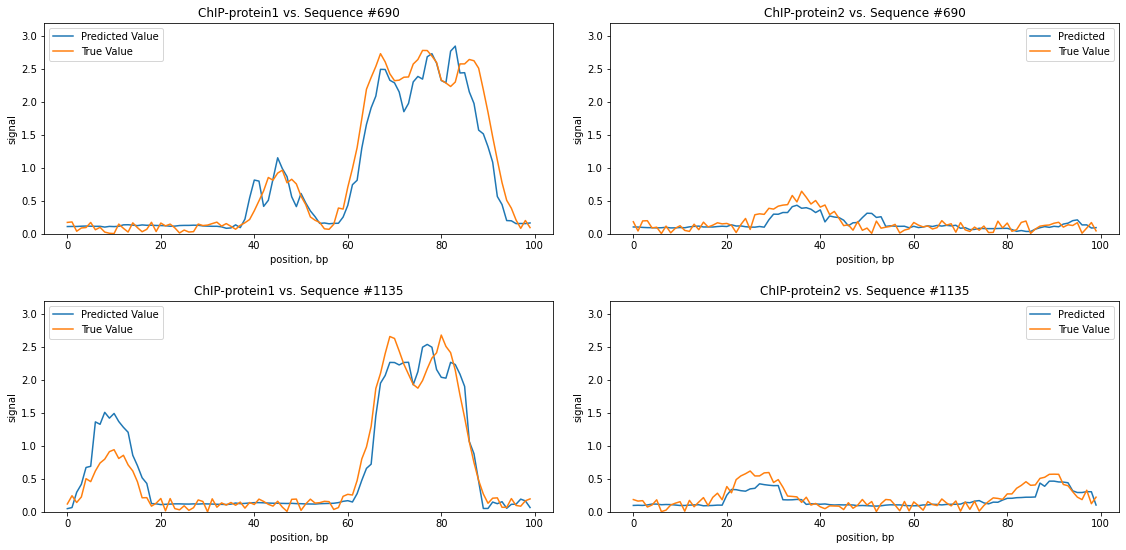

In [142]:
# Investigation of the prediction on randomly selected 2 sequences
nseqs = 2
fig, axes = plt.subplots(nseqs, 2, figsize=(16,nseqs*4))
for i in range(nseqs):
        seq = random.randint(0,test_features_2.shape[0]) 
        
        axes[i][0].plot(test_prediction_3[seq,:,0])
        axes[i][0].plot(test_labels_2[seq,:,0])
        axes[i][0].set_ylim((0, maxsignal_2))
        axes[i][0].set_title('ChIP-protein1 vs. Sequence #' + str(seq))
        axes[i][0].set(ylabel='signal', xlabel='position, bp')
        axes[i][0].legend(['Predicted Value', 'True Value'])
        
        axes[i][1].plot(test_prediction_3[seq,:,1])
        axes[i][1].plot(test_labels_2[seq,:,1])
        axes[i][1].set_ylim((0, maxsignal_2))
        axes[i][1].set_title('ChIP-protein2 vs. Sequence #' + str(seq))
        axes[i][1].set(ylabel='signal', xlabel='position, bp')
        axes[i][1].legend(['Predicted', 'True Value'])

fig.tight_layout(pad=2.0)
fig.show()

## Answer to Question 2.1 

Q: Does a model re-trained on this new dataset reach the same level of predictive ability?
-  Yes, it shows a better predictive ability. The mean square error was 0.16 for the prediction of the new data on the original model. After re-training the model with the new data, now the mse is decreased to 0.059 with r=0.888 for the training set; and to 0.077 with r=0.850 for the testing set. Now our re-trained model is able to predict higher signal values (it is no longer constrained to a maximum value of 1.20 as it was in the first model).

## 2.2 Can you determine different rule(s) for the influence on the profiles in this new cell type?

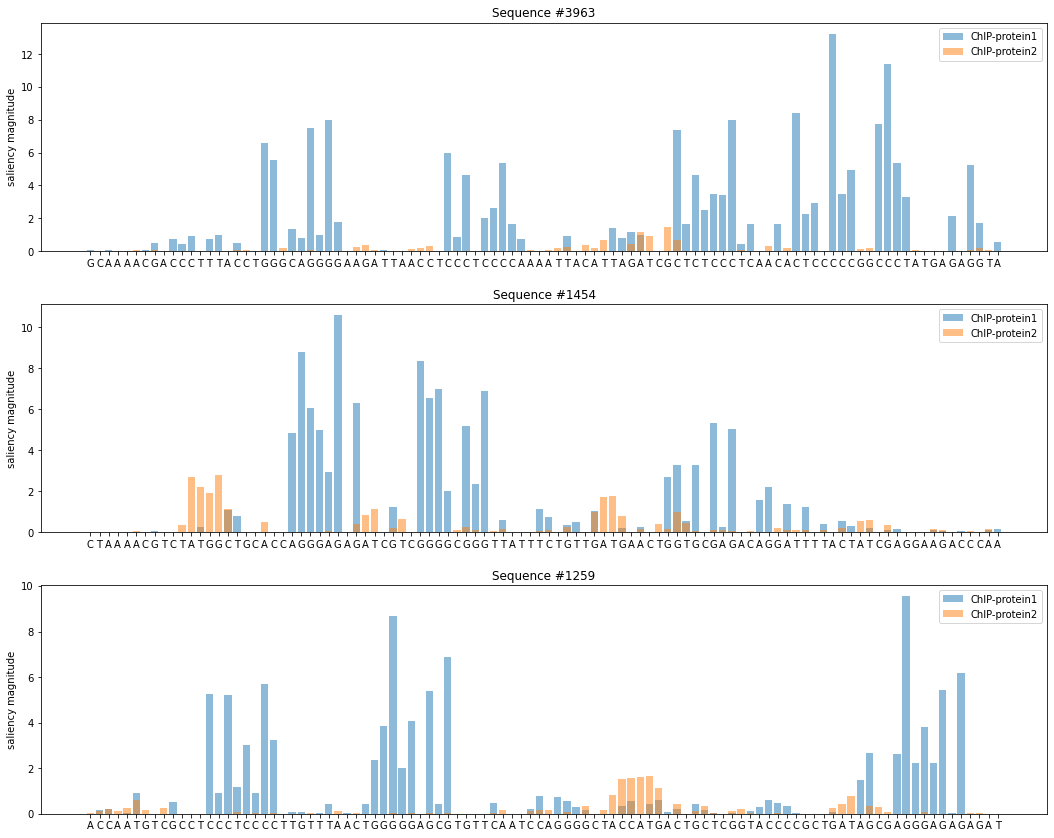

In [150]:
nbar = 100 # number of bp
nseqs = 3
sal_sequences = random.sample(range(0, 5001), nseqs)

fig, axes = plt.subplots(nseqs, 1, figsize=(15,nseqs*4))
counter = 0
for i in sal_sequences:
    sal_protein1 = compute_salient_bases(model, input_features_2[i], 0)
    sal_protein2 = compute_salient_bases(model, input_features_2[i], 1)

    axes[counter].bar(np.arange(nbar), sal_protein1, alpha=0.5, label = 'ChIP-protein1')
    axes[counter].bar(np.arange(nbar), sal_protein2, alpha=0.5, label = 'ChIP-protein2')
    axes[counter].set(ylabel='saliency magnitude')
    axes[counter].set_xticks(np.arange(nbar))
    axes[counter].set_xticklabels(list(sequences[i]))
    axes[counter].set_title('Sequence #' + str(i));
    axes[counter].legend()
    counter += 1

fig.tight_layout(pad=2.0)
fig.show()

## Answer to Question 2.2 

Q: Can you determine different rule(s) for the influence on the profiles in this new cell type?
- From the saliency figures of re-trained data, we still cannot see overlapping peaks between Protein 1 and Protein 2. Thus, we still cannot say that there are motifs or interplays between the two factors. The dataset we are provided did not help us to find an interaction between the factors. We cannot determine any rules.

